# Funadamental 15. Deep Learning with Numpy

딥러닝 프레임워크를 이용하면 몇 줄 안되는 코드만으로 MNIST 데이터셋을 99% 이상의 정확도로 분류할 수 있는 이미지 분류기를 만들 수 있으며, 이를 활용해서 다양한 카테고리의 이미지 분류기로 확장할 수 있다.

`Tensorflow`를 사용해 아래와 같이 MNIST 이미지 분류 모델을 구현 할 수 있다.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터를 로드. 다운로드하지 않았다면 다운로드까지 자동으로 진행됩니다. 
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

# 모델에 맞게 데이터 가공
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
x_train_reshaped = x_train_norm.reshape(-1, x_train_norm.shape[1]*x_train_norm.shape[2])
x_test_reshaped = x_test_norm.reshape(-1, x_test_norm.shape[1]*x_test_norm.shape[2])

# 딥러닝 모델 구성 - 2 Layer Perceptron
model=keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='sigmoid', input_shape=(784,)))  # 입력층 d=784, 은닉층 레이어 H=50
model.add(keras.layers.Dense(10, activation='softmax'))   # 출력층 레이어 K=10
model.summary()

# 모델 구성과 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train_reshaped, y_train, epochs=10)

# 모델 테스트 결과
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8290 - accuracy: 0.8108
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2441 - accuracy: 0.9322
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1850 - accuracy: 0.9471
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1528 - accuracy: 0.9566
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1285 - accuracy: 0.9640
Epoc

인공신경망의 실제 구현 원리를 보다 명확하게 이해하기 위해, 그동안 들춰보지 않았던 프레임워크 내부에서 일어나는 일을 Numpy를 활용해 직접 구현해보자.

## Parameters, Weights

In [2]:
# 입력층 데이터의 모양(shape)
print(x_train_reshaped.shape)

# 테스트를 위해 x_train_reshaped의 앞 5개의 데이터를 가져온다.
X = x_train_reshaped[:5]
print(X.shape)

(60000, 784)
(5, 784)


In [3]:
weight_init_std = 0.1
input_size = 784
hidden_size=50

# 인접 레이어간 관계를 나타내는 파라미터 W를 생성하고 random 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)  
# 바이어스 파라미터 b를 생성하고 Zero로 초기화
b1 = np.zeros(hidden_size)

a1 = np.dot(X, W1) + b1   # 은닉층 출력

print(W1.shape)
print(b1.shape)
print(a1.shape)

(784, 50)
(50,)
(5, 50)


In [4]:
# 단일 레이어 구현 함수
def affine_layer_forward(X, W, b):
    y = np.dot(X, W) + b
    cache = (X, W, b)
    return y, cache

## Activation Functions

In [5]:
# 위 수식의 sigmoid 함수를 구현해 봅니다.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  


z1 = sigmoid(a1)
print(z1[0])  # sigmoid의 출력은 모든 element가 0에서 1사이

[0.26390524 0.63106056 0.60116598 0.31773646 0.36543719 0.12229437
 0.60021896 0.74428202 0.59876258 0.76574893 0.26534045 0.55134929
 0.03749032 0.73699956 0.5926007  0.46339302 0.88153112 0.35851286
 0.7225068  0.27788059 0.3754259  0.45128955 0.31703203 0.369361
 0.4846993  0.26576593 0.73994846 0.7061886  0.80311133 0.34625307
 0.7099918  0.67509669 0.40164588 0.55323731 0.44801892 0.62871617
 0.56347226 0.45351599 0.64622419 0.52546016 0.37645857 0.34870831
 0.35513843 0.66196719 0.33195126 0.78948553 0.09831935 0.32469885
 0.77631985 0.31254014]


sigmoid 다음에 다시 Dense 레이어가 출현한다. 출력 노드 개수만 다를 뿐 동일한 구조입니다. 그렇다면 MLP 레이어를 아래와 같이 함수로 구현할 수 있다.

In [6]:
# 단일 레이어 구현 함수
def affine_layer_forward(X, W, b):
    y = np.dot(X, W) + b
    cache = (X, W, b)
    return y, cache

In [7]:
input_size = 784
hidden_size = 50
output_size = 10

W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)    # z1이 다시 두번째 레이어의 입력이 됩니다. 

print(a2[0])  # 최종 출력이 output_size만큼의 벡터가 되었습니다.

[ 0.04744956  0.31375866  0.05320329 -0.04925392 -0.46085205 -0.25914571
 -0.48645869 -0.54343351  0.34504656  0.18312109]


최종 출력인 `a2`에 softmax 함수를 적용하면 모델의 출력은 입력 X가 10가지 숫자 중 하나일 확률의 형태로 가공된다.

In [8]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [9]:
y_hat = softmax(a2)
y_hat[0]  

array([0.10883441, 0.14204397, 0.10946242, 0.09880262, 0.06546568,
       0.08009651, 0.0638106 , 0.06027663, 0.14655849, 0.12464867])

In [10]:
# 정답 라벨을 One-hot 인코딩하는 함수
def _change_one_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

Y_digit = y_train[:5]
t = _change_one_hot_label(Y_digit, 10)
t     # 정답 라벨의 One-hot 인코딩

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [11]:
print(y_hat[0])
print(t[0])

[0.10883441 0.14204397 0.10946242 0.09880262 0.06546568 0.08009651
 0.0638106  0.06027663 0.14655849 0.12464867]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [12]:
batch_num = y_hat.shape[0]
dy = (y_hat - t) / batch_num
dy    # softmax값의 출력으로 Loss를 미분한 값

array([[ 0.02176688,  0.02840879,  0.02189248,  0.01976052,  0.01309314,
        -0.1839807 ,  0.01276212,  0.01205533,  0.0293117 ,  0.02492973],
       [-0.17975727,  0.03017864,  0.02021959,  0.01941245,  0.01126083,
         0.01689275,  0.01393851,  0.01154803,  0.03422212,  0.02208435],
       [ 0.0237011 ,  0.02948237,  0.02540966,  0.01641073, -0.18978735,
         0.01561649,  0.01479889,  0.0109042 ,  0.0320069 ,  0.02145702],
       [ 0.01908193, -0.16993201,  0.02120276,  0.01889285,  0.01338442,
         0.02220483,  0.01405607,  0.01181776,  0.02741587,  0.02187552],
       [ 0.01956621,  0.02604181,  0.02092848,  0.01933141,  0.01356868,
         0.01772103,  0.01344586,  0.01103534,  0.03741053, -0.17904935]])

## Loss Functions

In [13]:
# 정답 라벨을 One-hot 인코딩하는 함수
def _change_ont_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

Y_digit = y_train[:5]
t = _change_ont_hot_label(Y_digit, 10)
t     # 정답 라벨의 One-hot 인코딩

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [14]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

Loss = cross_entropy_error(y_hat, t)
Loss

2.3881477175652597

## Gradient Descent

In [15]:
batch_num = y_hat.shape[0]
dy = (y_hat - t) / batch_num
dy    # softmax값의 출력으로 Loss를 미분한 값

array([[ 0.02176688,  0.02840879,  0.02189248,  0.01976052,  0.01309314,
        -0.1839807 ,  0.01276212,  0.01205533,  0.0293117 ,  0.02492973],
       [-0.17975727,  0.03017864,  0.02021959,  0.01941245,  0.01126083,
         0.01689275,  0.01393851,  0.01154803,  0.03422212,  0.02208435],
       [ 0.0237011 ,  0.02948237,  0.02540966,  0.01641073, -0.18978735,
         0.01561649,  0.01479889,  0.0109042 ,  0.0320069 ,  0.02145702],
       [ 0.01908193, -0.16993201,  0.02120276,  0.01889285,  0.01338442,
         0.02220483,  0.01405607,  0.01181776,  0.02741587,  0.02187552],
       [ 0.01956621,  0.02604181,  0.02092848,  0.01933141,  0.01356868,
         0.01772103,  0.01344586,  0.01103534,  0.03741053, -0.17904935]])

dy가 구해지면 다른 기울기들은 chain-rule로 쉽게 구할 수 있다.

In [16]:
dW2 = np.dot(z1.T, dy)    
db2 = np.sum(dy, axis=0)

중간에 sigmoid가 한번 사용되었으므로, 활성화함수에 대한 gradient도 고려한다.

In [17]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [18]:
dz1 = np.dot(dy, W2.T)
da1 = sigmoid_grad(a1) * dz1
dW1 = np.dot(X.T, da1)
db1 = np.sum(dz1, axis=0)

learning_rate도 고려를 하여 파라미터를 업데이트하는 함수를 정의하자.

In [19]:
learning_rate = 0.1

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    return W1, b1, W2, b2

## Backpropagation

affine_layer_forward(X, W, b)에 대응하여 생각해 보면 해당 레이어의 backpropagation 함수를 만들 수 있다.

In [20]:
def affine_layer_backward(dy, cache):
    X, W, b = cache
    dX = np.dot(dy, W.T)
    dW = np.dot(X.T, dy)
    db = np.sum(dy, axis=0)
    return dX, dW, db

위 과정을 통해 Forward Propagation과 Backward Propagation이 이루어지는 한 사이클을 아래와 같이 엮어 볼 수 있다.

In [21]:
# 파라미터 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

# Forward Propagation
a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)

# 추론과 오차(Loss) 계산
y_hat = softmax(a2)
t = _change_ont_hot_label(Y_digit, 10)   # 정답 One-hot 인코딩
Loss = cross_entropy_error(y_hat, t)

print(y_hat)
print(t)
print('Loss: ', Loss)
        
dy = (y_hat - t) / X.shape[0]
dz1, dW2, db2 = affine_layer_backward(dy, cache2)
da1 = sigmoid_grad(a1) * dz1
dX, dW1, db1 = affine_layer_backward(da1, cache1)

# 경사하강법을 통한 파라미터 업데이트    
learning_rate = 0.1
W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

[[0.1629072  0.10205027 0.0871849  0.03690095 0.08553424 0.08402313
  0.0927562  0.0880999  0.11439626 0.14614694]
 [0.14234871 0.10913804 0.09185538 0.03962454 0.08535264 0.07115312
  0.07451097 0.10169734 0.15213993 0.13217931]
 [0.14277873 0.112599   0.08454152 0.04227599 0.11104016 0.08981326
  0.08687212 0.10079157 0.10318525 0.1261024 ]
 [0.16795617 0.10213342 0.08682348 0.04440486 0.08285717 0.08799251
  0.08743328 0.099039   0.12290014 0.11845996]
 [0.12808293 0.09871113 0.09247266 0.03432466 0.10572351 0.07935199
  0.08716148 0.09672532 0.11346556 0.16398076]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.1426966709941766


## 모델 학습

In [22]:
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

def train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=False):
    a1, cache1 = affine_layer_forward(X, W1, b1)
    z1 = sigmoid(a1)
    a2, cache2 = affine_layer_forward(z1, W2, b2)
    y_hat = softmax(a2)
    t = _change_ont_hot_label(Y, 10)
    Loss = cross_entropy_error(y_hat, t)

    if verbose:
        print('---------')
        print(y_hat)
        print(t)
        print('Loss: ', Loss)
        
    dy = (y_hat - t) / X.shape[0]
    dz1, dW2, db2 = affine_layer_backward(dy, cache2)
    da1 = sigmoid_grad(a1) * dz1
    dX, dW1, db1 = affine_layer_backward(da1, cache1)
    
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    return W1, b1, W2, b2, Loss

In [23]:
X = x_train_reshaped[:5]
Y = y_train[:5]

# train_step을 다섯 번 반복 돌립니다.
for i in range(5):
    W1, b1, W2, b2, _ = train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=True)

---------
[[0.09339471 0.04248273 0.13503946 0.05860919 0.10154272 0.09879126
  0.15725866 0.13264596 0.060242   0.11999331]
 [0.107262   0.04177426 0.1504036  0.05435546 0.10287041 0.09420832
  0.16218741 0.11927546 0.05864536 0.10901772]
 [0.07589836 0.04888933 0.14085082 0.0679027  0.08760608 0.09782427
  0.15231145 0.14710828 0.05290995 0.12869877]
 [0.10513945 0.04426112 0.1335127  0.05699658 0.10501071 0.11064156
  0.15242733 0.12766821 0.05383744 0.1105049 ]
 [0.10161571 0.05052207 0.14674969 0.05740623 0.08914823 0.10745151
  0.12455904 0.1491024  0.04683708 0.12660804]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.4332879479315768
---------
[[0.11408139 0.05386074 0.11090332 0.0544783  0.11628996 0.12132735
  0.12674071 0.11028678 0.05626164 0.1357698 ]
 [0.13899437 0.05418291 0.1202756  0.05001611 0.11896932 0.11299411
  0.12790571 0.09655432 0.054

## 추론 과정 구현과 정확도(Accuracy) 계산

In [25]:
def predict(W1, b1, W2, b2, X):
    a1 = np.dot(X, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

In [26]:
# X = x_train[:100] 에 대해 모델 추론을 시도합니다. 

X = x_train_reshaped[:100]
Y = y_test[:100]
result = predict(W1, b1, W2, b2, X)
result[0]

array([0.16214698, 0.09619185, 0.05855763, 0.03678507, 0.14103227,
       0.18798574, 0.06433169, 0.05904789, 0.03795225, 0.15596862])

In [27]:
def accuracy(W1, b1, W2, b2, x, y):
    y_hat = predict(W1, b1, W2, b2, x)
    y_hat = np.argmax(y_hat, axis=1)
   # t = np.argmax(t, axis=1)

    accuracy = np.sum(y_hat == y) / float(x.shape[0])
    return accuracy

In [28]:
acc = accuracy(W1, b1, W2, b2, X, Y)

t = _change_ont_hot_label(Y, 10)
print(result[0])
print(t[0])
print(acc)

[0.16214698 0.09619185 0.05855763 0.03678507 0.14103227 0.18798574
 0.06433169 0.05904789 0.03795225 0.15596862]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0.08


## 전체 학습 사이클 수행

In [29]:
# 학습시킬 파라미터를 초기화하는 함수
def init_params(input_size, hidden_size, output_size, weight_init_std=0.01):

    W1 = weight_init_std * np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = weight_init_std * np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)

    print(W1.shape)
    print(b1.shape)
    print(W2.shape)
    print(b2.shape)
    
    return W1, b1, W2, b2

In [30]:
# 하이퍼파라미터
iters_num = 50000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

W1, b1, W2, b2 = init_params(784, 50, 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train_reshaped[batch_mask]
    y_batch = y_train[batch_mask]
    
    W1, b1, W2, b2, Loss = train_step(x_batch, y_batch, W1, b1, W2, b2, learning_rate=0.1, verbose=False)

    # 학습 경과 기록
    train_loss_list.append(Loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        print('Loss: ', Loss)
        train_acc = accuracy(W1, b1, W2, b2, x_train_reshaped, y_train)
        test_acc = accuracy(W1, b1, W2, b2, x_test_reshaped, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

(784, 50)
(50,)
(50, 10)
(10,)
Loss:  2.3009319579526983
train acc, test acc | 0.09736666666666667, 0.0982
Loss:  0.8077654284030023
train acc, test acc | 0.7883333333333333, 0.7899
Loss:  0.47335996359950483
train acc, test acc | 0.8769833333333333, 0.8796
Loss:  0.3167373073186053
train acc, test acc | 0.8975666666666666, 0.9021
Loss:  0.25351652962297655
train acc, test acc | 0.907, 0.9108
Loss:  0.25546877562962844
train acc, test acc | 0.91445, 0.9159
Loss:  0.2819074148213252
train acc, test acc | 0.9189166666666667, 0.9203
Loss:  0.29942099028680275
train acc, test acc | 0.9239333333333334, 0.9255
Loss:  0.43182325953006734
train acc, test acc | 0.9262, 0.9259
Loss:  0.2597094177390444
train acc, test acc | 0.9301166666666667, 0.9325
Loss:  0.17218113237991736
train acc, test acc | 0.9332166666666667, 0.934
Loss:  0.3431769194420081
train acc, test acc | 0.9366166666666667, 0.9355
Loss:  0.16956513399939585
train acc, test acc | 0.9388666666666666, 0.9393
Loss:  0.15327199012966

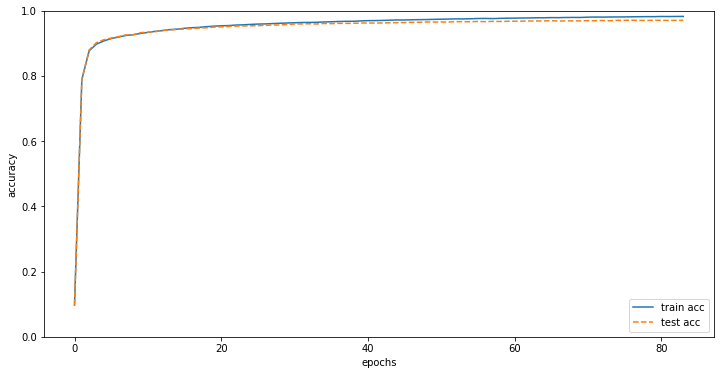

In [31]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6 

# Accuracy 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

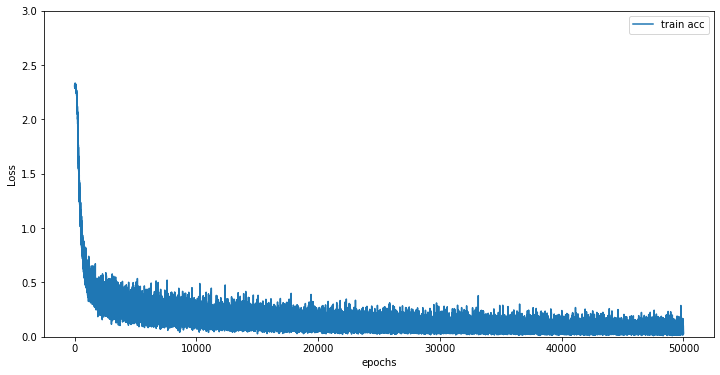

In [32]:
# Loss 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 3.0)
plt.legend(loc='best')
plt.show()